In [13]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torchvision.models as models
from scipy.stats import pearsonr


In [3]:
path_to_images = "./BMI/Data/Images"
bmi_data = pd.read_csv("./BMI/Data/data.csv")

In [ ]:
import os

image_folder = "./BMI/Data/Images"

# Count total rows before filtering
before = len(bmi_data)

# Keep only rows where the image file exists
bmi_data = bmi_data[bmi_data['name'].apply(lambda fname: os.path.exists(os.path.join(image_folder, fname)))].reset_index(drop=True)

# Count total rows after filtering
after = len(bmi_data)

# Report how many were dropped
print(f"Valid image entries: {after}/{before} (Dropped {before - after} missing)")

Valid image entries: 3958/3962 (Dropped 4 missing)


In [5]:
bmi_data.head()

,Unnamed: 0,bmi,gender,is_training,name
0,0,34.207396,Male,1,img_0.bmp
1,1,26.453720,Male,1,img_1.bmp
2,2,34.967561,Female,1,img_2.bmp
3,3,22.044766,Female,1,img_3.bmp
4,6,25.845588,Female,1,img_6.bmp


In [6]:
class BMIDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.data = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data.iloc[idx]['name'])
        image = Image.open(img_path).convert("RGB")
        label = self.data.iloc[idx]['bmi']

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

In [ ]:
class BMIDatasetGender(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.data = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data.iloc[idx]['name'])
        image = Image.open(img_path).convert("RGB")
        bmi = self.data.iloc[idx]['bmi']
        gender = self.data.iloc[idx]['gender']  # assumes gender column exists (e.g., 'Male' or 'Female')

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(bmi, dtype=torch.float32), gender

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [16]:
train_df = bmi_data[bmi_data['is_training'] == 1]
test_df = bmi_data[bmi_data['is_training'] == 0]

train_dataset = BMIDataset(train_df, path_to_images, transform)
test_dataset = BMIDataset(test_df, path_to_images, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)  # Replace final layer

model = model.to(device)

/opt/anaconda3/envs/bayes/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/bayes/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

Epoch 1, Loss: 841.5256
Epoch 2, Loss: 507.3380
Epoch 3, Loss: 320.8967
Epoch 4, Loss: 184.3296
Epoch 5, Loss: 94.7529
Epoch 6, Loss: 43.8090
Epoch 7, Loss: 18.3221
Epoch 8, Loss: 8.7604
Epoch 9, Loss: 5.1802
Epoch 10, Loss: 4.2157


In [19]:
torch.save(model.state_dict(), "resnet_bmi_weights.pth")

In [20]:
model.eval()
preds, labels = [], []

with torch.no_grad():
    for images, targets in test_loader:
        images = images.to(device)
        outputs = model(images).squeeze().cpu().numpy()
        preds.extend(outputs)
        labels.extend(targets.numpy())

from sklearn.metrics import mean_squared_error, r2_score
print("MSE:", mean_squared_error(labels, preds))
print("R² Score:", r2_score(labels, preds))

MSE: 53.999628013476446
R² Score: 0.3639082374155037


In [22]:
from scipy.stats import pearsonr
r_value, _ = pearsonr(labels, preds)
print("Pearson r:", r_value)

Pearson r: 0.6525977


In [21]:
import numpy as np

threshold = 1.0 # Adjust as needed
labels_np = np.array(labels)
preds_np = np.array(preds)

accuracy_within_threshold = np.mean(np.abs(labels_np - preds_np) <= threshold)
print(f"Accuracy within ±{threshold} BMI: {accuracy_within_threshold:.2%}")

Accuracy within ±1.0 BMI: 15.43%


In [16]:
train_df = bmi_data[bmi_data['is_training'] == 1]
test_df = bmi_data[bmi_data['is_training'] == 0]

train_dataset = BMIDatasetGender(train_df, path_to_images, transform)
test_dataset = BMIDatasetGender(test_df, path_to_images, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
model.eval()
preds, labels, genders = [], [], []

with torch.no_grad():
    for images, targets, gender_batch in test_loader:
        images = images.to(device)
        outputs = model(images).squeeze().cpu().numpy()
        preds.extend(outputs)
        labels.extend(targets.numpy())
        genders.extend(gender_batch)  # gender_batch is a list of strings (e.g., 'Male', 'Female')

In [32]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

preds = np.array(preds)
labels = np.array(labels)
genders = np.array(genders)

for gender in ['Male', 'Female']:
    idx = np.where(genders == gender)[0]
    gender_preds = preds[idx]
    gender_labels = labels[idx]

    print(f"\n--- Gender: {gender} ---")
    print("MSE:", mean_squared_error(gender_labels, gender_preds))
    print("R² Score:", r2_score(gender_labels, gender_preds))
    r, _ = pearsonr(gender_labels, gender_preds)
    print("Pearson r:", round(r, 4))


--- Gender: Male ---
MSE: 48.5145263671875
R² Score: 0.39741820096969604
Pearson r: 0.6928

--- Gender: Female ---
MSE: 61.206207275390625
R² Score: 0.3206917643547058
Pearson r: 0.6013


Checking for Overfitting


In [36]:
model.eval()
train_preds, train_labels, train_genders = [], [], []

with torch.no_grad():
    for images, targets, gender_batch in train_loader:
        images = images.to(device)
        outputs = model(images).squeeze().cpu().numpy()
        train_preds.extend(outputs)
        train_labels.extend(targets.numpy())
        train_genders.extend(gender_batch)  # gender_batch is a list of strings (e.g., 'Male', 'Female')

In [37]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

preds = np.array(train_preds)
labels = np.array(train_labels)
genders = np.array(train_genders)

for gender in ['Male', 'Female']:
    idx = np.where(genders == gender)[0]
    gender_preds = preds[idx]
    gender_labels = labels[idx]

    print(f"\n--- Gender: {gender} ---")
    print("MSE:", mean_squared_error(gender_labels, gender_preds))
    print("R² Score:", r2_score(gender_labels, gender_preds))
    r, _ = pearsonr(gender_labels, gender_preds)
    print("Pearson r:", round(r, 4))


--- Gender: Male ---
MSE: 2.7148563861846924
R² Score: 0.9548702836036682
Pearson r: 0.9902

--- Gender: Female ---
MSE: 2.4232895374298096
R² Score: 0.965533971786499
Pearson r: 0.9907


---

# Final Model

In [19]:
import torch
from sklearn.metrics import r2_score
import numpy as np

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

best_val_loss = float('inf')
patience = 2
trigger_times = 0
num_epochs = 8

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, targets, genders in train_loader:
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    val_preds, val_labels, val_genders = [], [], []

    with torch.no_grad():
        for images, targets, genders in test_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            val_preds.extend(outputs.cpu().numpy())
            val_labels.extend(targets.cpu().numpy())
            val_genders.extend(genders)

    val_loss /= len(test_loader)
    val_r2 = r2_score(val_labels, val_preds)

    val_preds = np.array(val_preds)
    val_labels = np.array(val_labels)
    val_genders = np.array(val_genders)

    for gender in ['Male', 'Female']:
        idx = np.where(val_genders == gender)[0]
        if len(idx) > 1:
            r, _ = pearsonr(val_labels[idx], val_preds[idx])
            print(f"Val Pearson r ({gender}): {r:.3f}")
        else:
            print(f"Val Pearson r ({gender}): N/A (not enough samples)")

    if len(val_labels) > 1:
        r_all, _ = pearsonr(val_labels, val_preds)
        print(f"Val Pearson r (All): {r_all:.3f}")
    else:
        print("Val Pearson r (All): N/A (not enough samples)")

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val R²: {val_r2:.3f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), "best_model_resnet.pth")  # Save best model
    else:
        trigger_times += 1
        print(f"→ Early stopping counter: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("⛔ Early stopping triggered.")
            break

Val Pearson r (Male): 0.320
Val Pearson r (Female): 0.358
Val Pearson r (All): 0.318
Epoch 1: Train Loss: 833.8973 | Val Loss: 662.6284 | Val R²: -6.797
Val Pearson r (Male): 0.613
Val Pearson r (Female): 0.588
Val Pearson r (All): 0.593
Epoch 2: Train Loss: 496.0797 | Val Loss: 434.9244 | Val R²: -4.120
Val Pearson r (Male): 0.658
Val Pearson r (Female): 0.582
Val Pearson r (All): 0.622
Epoch 3: Train Loss: 313.3855 | Val Loss: 289.3229 | Val R²: -2.401
Val Pearson r (Male): 0.678
Val Pearson r (Female): 0.606
Val Pearson r (All): 0.646
Epoch 4: Train Loss: 178.9705 | Val Loss: 155.4014 | Val R²: -0.831
Val Pearson r (Male): 0.671
Val Pearson r (Female): 0.611
Val Pearson r (All): 0.645
Epoch 5: Train Loss: 88.4842 | Val Loss: 84.3251 | Val R²: 0.005
Val Pearson r (Male): 0.674
Val Pearson r (Female): 0.585
Val Pearson r (All): 0.636
Epoch 6: Train Loss: 39.4635 | Val Loss: 57.0680 | Val R²: 0.328
Val Pearson r (Male): 0.676
Val Pearson r (Female): 0.597
Val Pearson r (All): 0.642
Epo

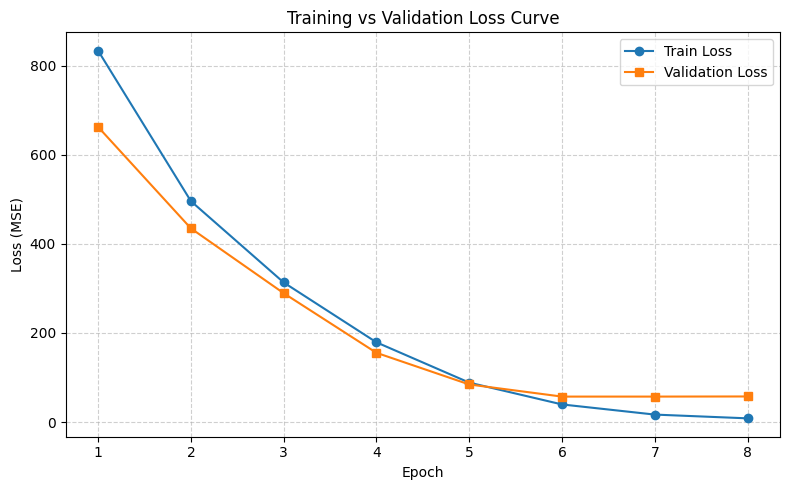

In [29]:
import matplotlib.pyplot as plt

# Provided loss values
train_loss = [833.8973, 496.0797, 313.3855, 178.9705, 88.4842, 39.4635, 16.6734, 8.2327]
val_loss =   [662.6284, 434.9244, 289.3229, 155.4014, 84.3251, 57.0680, 57.0804, 57.3631]

epochs = list(range(1, len(train_loss) + 1))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss, marker='s', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss Curve')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
!pip install torchsummary

In [28]:
from torchsummary import summary

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
import torch
from torchvision import transforms
from PIL import Image

# Define image transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)  # Replace final layer

model = model.to(device)
model.load_state_dict(torch.load("best_model_resnet.pth", map_location='cpu'))
model.eval()

# If using GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Load and preprocess image
img = Image.open('./Utku3.jpg').convert('RGB')
img_tensor = transform(img).unsqueeze(0).to(device)

# Predict
with torch.no_grad():
    bmi_prediction = model(img_tensor).squeeze().item()

print(f"Predicted BMI: {bmi_prediction:.2f}")

In [ ]:
img_path = './Utku3.jpg'
img = Image.open(img_path).convert('RGB') 
img_tensor = transform(img).unsqueeze(0)  
img_tensor = img_tensor.to(device)

In [21]:
with torch.no_grad():
    prediction = model(img_tensor).squeeze().item()

print(f"Predicted BMI for Utku3.jpg: {prediction:.2f}")

Predicted BMI for Utku3.jpg: 25.48


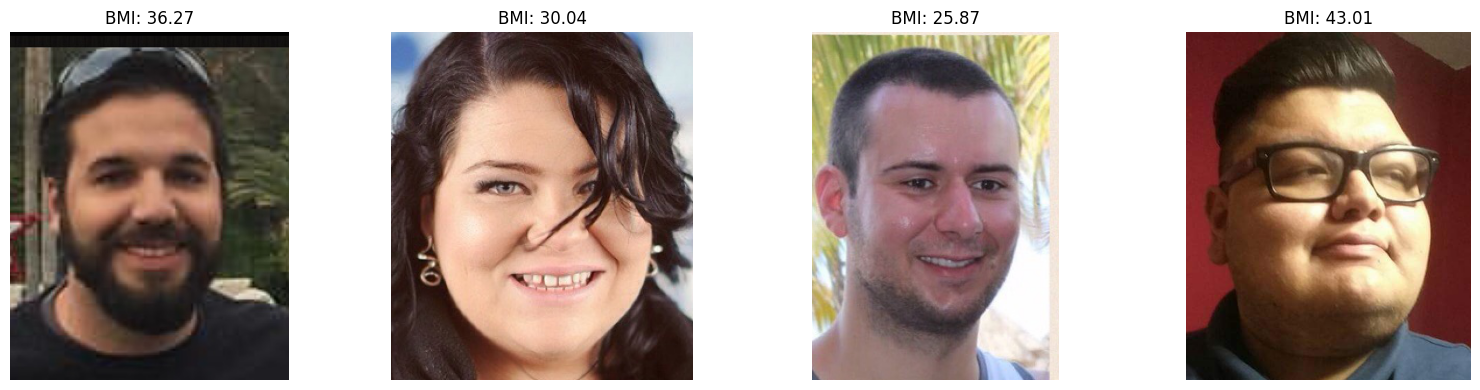

In [22]:

import matplotlib.pyplot as plt

# Load and predict all images in ./test/
image_dir = "./test"
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.bmp'))]

predictions = []
images = []

for fname in image_files:
    path = os.path.join(image_dir, fname)
    img = Image.open(path).convert('RGB')
    images.append(img)

    input_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(input_tensor).squeeze().item()
    predictions.append(pred)

# Plot
cols = 4
rows = (len(images) + cols - 1) // cols
plt.figure(figsize=(cols * 4, rows * 4))

for i, (img, pred) in enumerate(zip(images, predictions)):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"BMI: {pred:.2f}", fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [32]:
# model.eval()
# test_preds, test_labels, test_genders = [], [], []

# with torch.no_grad():
#     for images, targets, gender_batch in test_loader:
#         images = images.to(device)
#         outputs = model(images).squeeze().cpu().numpy()
#         test_preds.extend(outputs)
#         test_labels.extend(targets.numpy())
#         test_genders.extend(gender_batch)  # gender_batch is a list of strings (e.g., 'Male', 'Female')

In [33]:
# import numpy as np
# from sklearn.metrics import mean_squared_error, r2_score
# from scipy.stats import pearsonr

# preds = np.array(test_preds)
# labels = np.array(test_labels)
# genders = np.array(test_genders)

# for gender in ['Male', 'Female']:
#     idx = np.where(genders == gender)[0]
#     gender_preds = preds[idx]
#     gender_labels = labels[idx]

#     print(f"\n--- Gender: {gender} ---")
#     print("MSE:", mean_squared_error(gender_labels, gender_preds))
#     print("R² Score:", r2_score(gender_labels, gender_preds))
#     r, _ = pearsonr(gender_labels, gender_preds)
#     print("Pearson r:", round(r, 4))

# r, _ = pearsonr(labels, preds)
# print("Pearson r (total):", round(r, 4))